# kinetic Modeling with ODE Solver

Description

### Imports
Import packages and set global varibales used in this notebook

In [1]:
import os # operating system to work with directories and files
import matplotlib.pyplot as plt # plot data and results
import seaborn as sns # prettier visualization
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver
from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting
from pyenzyme.enzymeml.tools import EnzymeMLReader # EnzymeML document functionalities

## Select EnzymeML document
Select the EnzymeML document created with BioCatHub, by changing the path vriable accodingly. <br>
The whole EnzymeML document is stored in the enzmldoc varible. <br>
Prints a short overview.

In [2]:
path = 'datasets/Hathaway/Experiment Hathaway.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmldoc = EnzymeMLReader().readFromFile(path)
    print(enzmldoc)
else:
    print('Incorrect file path.')

>>> Units
	ID: u0 	 Name: ml
	ID: u1 	 Name: K
	ID: u2 	 Name: mmole / l
	ID: u3 	 Name: ug
	ID: u4 	 Name: sec
>>> Reactants
	ID: s0 	 Name: ADP
	ID: s1 	 Name: ATP
	ID: s2 	 Name: AMP
>>> Proteins
	ID: p0 	 Name: thermostable adenylate kinase
>>> Reactions
	ID: r0 	 Name: ATP formation


## Visualization of timecourse data
A short visualisation to get a first impression of the data. <br>
First select the reaction to visualize by changing the reaction_id accordingly, see overview above for selction options.

In [3]:
#basic/general settings
sns.set_theme(style="whitegrid", palette ='bright',color_codes=True, context = 'notebook')

# set reaction id to 'r0' or 'r1'
reaction_id = 'r0'
reaction = enzmldoc.getReaction(reaction_id)
reaction_name = reaction.getName()
educts = reaction.getEducts() # list of tuples: (Reactant ID, stoichiometry, Constant, Replicate, Initial-Concentration)
products = reaction.getProducts()

Visualize educts, if the EnzymeML document contains time course data for educts

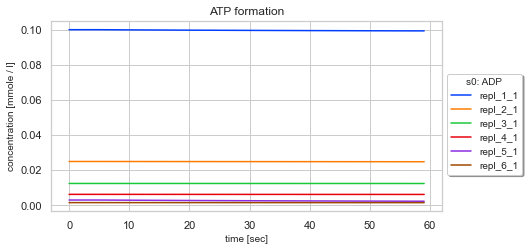

In [4]:
# Educts:
for reactant_id, stoich, _, replicates, init_conc in educts:
        
    if len(replicates) > 0:
            
        df = reaction.exportReplicates(reactant_id)
        time_val = df.index.tolist()
        time = df.index.name.split('/')[0]
        time_unit_name = df.index.name.split('/')[1]
        time_unit = enzmldoc.getUnitDict()[time_unit_name].getName()
            
        f, ax = plt.subplots(figsize=(7,3.5))
            
        # Visualization
        for col in df.columns:
                
            name = col.split('/')[1]+': '+enzmldoc.getReactant(col.split('/')[1]).getName()
            unit_name = enzmldoc.getReactant(col.split('/')[1]).getSubstanceUnits()
            unit = enzmldoc.getUnitDict()[unit_name].getName()
                
            sns.lineplot( x=time_val, y=df[col], label = col.split('/')[0] )
            
        #set graph title, legend, axes 
        ax.set_title(reaction_name, fontsize = 12)

        ax.legend(fontsize = 10, \
                    bbox_to_anchor= (1, 0.75), \
                    title= name, \
                    title_fontsize = 10, \
                    shadow = True, \
                    facecolor = 'white');

        xlabel = f"{time} [{time_unit}]"
        ylabel = f"{'concentration'} [{unit}]"

        ax.set_xlabel(xlabel , fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)

Visualize products, if the EnzymeML document contains time course data for products <br>
The example data does not contain measurments of products.

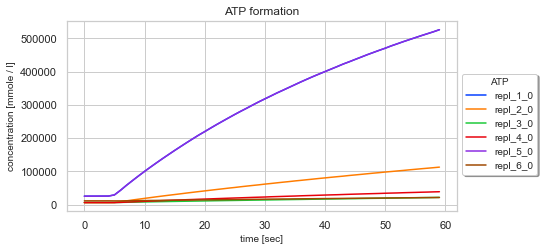

In [5]:
for reactant_id, stoich, _, replicates, init_conc in products:
        
    if len(replicates) > 0:
            
        df = reaction.exportReplicates(reactant_id)
        time_val = df.index.tolist()
        time = df.index.name.split('/')[0]
        time_unit_name = df.index.name.split('/')[1]
        time_unit = enzmldoc.getUnitDict()[time_unit_name].getName()
            
        f, ax = plt.subplots(figsize=(7,3.5))
            
        # Visualization
        for col in df.columns:
                
            name = enzmldoc.getReactant(col.split('/')[1]).getName()
            unit_name = enzmldoc.getReactant(col.split('/')[1]).getSubstanceUnits()
            unit = enzmldoc.getUnitDict()[unit_name].getName()
                
            sns.lineplot( x=time_val, y=df[col], label = col.split('/')[0] )
            
        #set graph title, legend, axes 
        ax.set_title(reaction_name, fontsize = 12)

        ax.legend(fontsize = 10, \
                    bbox_to_anchor= (1, 0.75), \
                    title= name, \
                    title_fontsize = 10, \
                    shadow = True, \
                    facecolor = 'white');

        xlabel = f"{time} [{time_unit}]"
        ylabel = f"{'concentration'} [{unit}]"

        ax.set_xlabel(xlabel , fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)

## Parameter Estimation and Modeling
#### Data preparation
Convert pandas dataframe from EnzymeML data to numpy arrays. <br>
First select the reactant to model by changing the reactant_id accordingly, see overview above for selction options.<br>
In this example substrate 's0' will be modeled.<br>
##### Choose against which timecourse you want to fit.

In [6]:
reactant_id = 's0'
is_product = False
lag = 5
replicates = reaction.exportReplicates(reactant_id)
# time:
data_time = replicates.index.values # numpy array shape (9,)
data_time = data_time[lag:]
# substrate data (absorption):
data_s = np.transpose(replicates.iloc[lag:,:].to_numpy(np.float64)) # shape: (4, 9)
#data_s = np.transpose(replicates.iloc[:,:-1].to_numpy(np.float64)) # shape: (3, 9)
#data_s = np.transpose(replicates.iloc[:,:-2].to_numpy(np.float64)) # shape: (2, 9)
#data_s = np.transpose(replicates.iloc[lag:,0].to_numpy(np.float64)) # shape: (1, 9)
#print(data_s.shape)

In [7]:
# if product "cheating"
if is_product:
    for i in range(data_s.shape[0]):
        grr = np.transpose(replicates.iloc[lag:,:].to_numpy(np.float64))
        init = np.max(grr[i])
        temp = np.full(data_s[i].shape,init)
        data_s[i]= temp-data_s[i]
#print(data_s)

### Fit data to a system of ODEs
#### Define the ODE functions

In [8]:
# not used
def michaelis_menten_with_lag(w, t, params):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,S]
        t: time
        params: parameters
    '''
    v, s = w
    
    a = params['a'].value
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(v',s'):
    f0 = a*(vmax-v) # v'
    f1 = -v*s/(km+s) # S'
    return [f0,f1]

In [9]:
def michaelis_menten(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f1 = -vmax*s/(km+s) # S'
    return f1

In [10]:
def hill_equation(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    n = params['n'].value
    
    # f(s'):
    f1 = -vmax*(s**n)/(km+(s**n)) # S'
    return f1

#### Solve ODE

In [11]:
# not used
def solve_MM_with_lag(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(michaelis_menten_with_lag, w0, t, args=(params,))
    return w

In [12]:
def solve_MM(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(michaelis_menten, w0, t, args=(params,))
    return w

In [13]:
def solve_Hill(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(hill_equation, w0, t, args=(params,))
    return w

#### Compute residual between actual data (S) and fitted data
In this model we assume that the data contains a bias on the y-axis. <br>
Therfore we compute the distance between the modeled substrate + bias and the actual mesuared substrate

In [14]:
# not used
def residual_with_lag_and_bias(params, t, data_s):
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 3 measurments => ndata = 3)
    resid = 0.0*data_s[:] # initialize the residual vector
    # compute residual per data set
    for i in range(ndata):
        w0 = params['v0'].value, params['S0'].value
        model = solve_MM_with_lag(t, w0, params) # solve the ODE with the given parameters
        # get modeled substrate
        s_model = model[:,1]
        s_model_b = s_model + params['b'].value # adding bias
        resid[i,:]=data_s[i,:]-s_model_b # compute distance to measured data
    return resid.flatten()

In [15]:
def residual_MM(params, t, data_s):
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 4 measurments => ndata = 4)
    resid = 0.0*data_s[:] # initialize the residual vector
    # compute residual per data set
    for i in range(ndata):
        w0 = data_s[i,0]
        model = solve_MM(t, w0, params) # solve the ODE with the given parameters
        # get modeled substrate
        s_model = model[:,0]
        resid[i,:]=data_s[i,:]-s_model # compute distance to measured data
    return resid.flatten()

In [16]:
def residual_MM_single(params, t, data_s):
    w0 = data_s[0]
    model = solve_MM(t, w0, params)
    # only have data for s not v
    s_model = model[:,0]
    return (s_model - data_s).ravel()

In [17]:
def residual_Hill(params, t, data_s):
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 4 measurments => ndata = 4)
    resid = 0.0*data_s[:] # initialize the residual vector
    # compute residual per data set
    for i in range(ndata):
        w0 = data_s[i,0]
        model = solve_Hill(t, w0, params) # solve the ODE with the given parameters
        # get modeled substrate
        s_model = model[:,0]
        resid[i,:]=data_s[i,:]-s_model # compute distance to measured data
    return resid.flatten()

In [18]:
def residual_Hill_single(params, t, data_s):
    w0 = data_s[0]
    model = solve_Hill(t, w0, params)
    # only have data for s not v
    s_model = model[:,0]
    return (s_model - data_s).ravel()

#### Functions to compute initial value for vmax and Km
To get a good guess for vmax, v is computed for each time step. <br>
For Km the mean of s values at aproximatly vmax/2 is taken.

In [19]:
def get_v(time, data_s):
    v_all = 0.0*data_s[:] # initialize velocity vector
    if len(data_s.shape)>1:
        for i in range(data_s.shape[0]):
            prev_value = data_s[i,0]
            prev_time = 0.0
            for j in range(data_s.shape[1]):
                if time[j] == 0:
                    delta = prev_value - data_s[i,j]
                else:
                    delta = abs( (prev_value - data_s[i,j])/(time[j]-prev_time))
                v_all[i,j] = delta
                prev_value = data_s[i,j]
                prev_time = time[j]
        v = np.max(v_all, axis=0)
    else:
        prev_value = data_s[0]
        prev_time = 0.0
        for j in range(data_s.shape[0]):
            if time[j] == 0:
                delta = prev_value - data_s[j]
            else:
                delta = abs( (prev_value - data_s[j])/(time[j]-prev_time))
            v_all[j] = delta
            prev_value = data_s[j]
            prev_time = time[j]
        v = v_all
    return v

In [20]:
def get_initial_vmax(time, data_s):
    v = get_v(time,data_s)
    return np.max(v)

In [21]:
def get_initial_Km(time, data_s):
    v = get_v(time,data_s)
    idx_max = np.where(v == np.max(v))[0][0]
    idx_Km = (np.abs(v[idx_max:]-np.max(v)/2)).argmin()
    if len(data_s.shape)>1:
        km = np.mean(data_s,axis=0)[idx_max+idx_Km]
    else:
        km = data_s[idx_max+idx_Km]
    return km

#### Bringing everything together
Initialize parameters:
- $v_0$ is fixed on 0.
- bias is estimated by taking the mean of the last data point for all measured data.
- for $S_0$ the mean of first data point for all measured data is taken and substracted by the estimated bias.
- functions to get initial values for $v_{max}$ and $K_m$ are called.
- initial value for a is set to 1.

In [22]:
# time
t_measured = data_time[:]

# initial conditions:
#v0 = 0
if len(data_s.shape)>1:
    s0 = np.max(data_s,axis=0)[0]
else:
    s0 = data_s[0]

# Set parameters including bounds
#bias = np.min(data_s,axis=0)[-1]
vmax = get_initial_vmax(t_measured, data_s)
km = get_initial_Km(t_measured, data_s)

Parameters for different Models

In [23]:
# 'standard' Michaelis Menten
params_MM = Parameters()
params_MM.add('vmax', value=vmax, min=0.0)
params_MM.add('Km', value=km, min=0.0001)

In [24]:
# Hill equation
n = 2

params_Hill = Parameters()
params_Hill.add('vmax', value=vmax, min=0.0)
params_Hill.add('Km', value=km, min=0.0001)
params_Hill.add('n', value=n, min=0.99, max=3)

#### Fit model and visualize results
Statistics for the Fit and the parameters a printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 330
    # variables        = 2
    chi-square         = 1.0160e-05
    reduced chi-square = 3.0976e-08
    Akaike info crit   = -5703.72817
    Bayesian info crit = -5696.12999
[[Variables]]
    vmax:  8.1636e-05 +/- 9.2252e-05 (113.00%) (init = 2.003577e-05)
    Km:    0.48794348 +/- 0.65280338 (133.79%) (init = 0.02451704)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.999


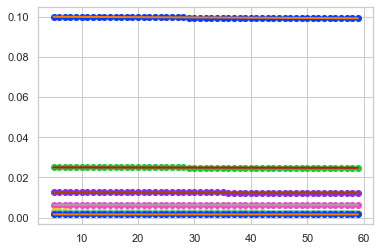

In [25]:
# 'standard' Michaelis Menten
if len(data_s.shape)>1:
    result = minimize(residual_MM , params_MM, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    for i in range(data_s.shape[0]):
        plt.plot(t_measured, data_s[i, :], 'o')
        #w0 = params['v0'].value, data_s[i,0]
        w0 = data_s[i,0]
        data_fitted = solve_MM(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()
else:
    result = minimize(residual_MM_single , params_MM, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    plt.plot(t_measured, data_s[:], 'o')
    w0 = data_s[0]
    data_fitted = solve_MM(t_measured, w0, result.params)
    plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()

$v_{max} = k_{cat} * E_0$

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 742
    # data points      = 330
    # variables        = 3
    chi-square         = 1.0149e-05
    reduced chi-square = 3.1038e-08
    Akaike info crit   = -5702.06941
    Bayesian info crit = -5690.67213
[[Variables]]
    vmax:  8.1374e-05 +/- 4.2033e-04 (516.55%) (init = 2.003577e-05)
    Km:    0.49810090 +/- 3.64513165 (731.81%) (init = 0.02451704)
    n:     0.99000000 +/- 0.43113138 (43.55%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.999
    C(Km, n)    =  0.983
    C(vmax, n)  =  0.976


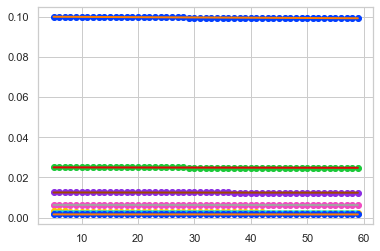

In [26]:
# Hill equation
if len(data_s.shape)>1:
    result = minimize(residual_Hill , params_Hill, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    for i in range(data_s.shape[0]):
        plt.plot(t_measured, data_s[i, :], 'o')
        #w0 = params['v0'].value, data_s[i,0]
        w0 = data_s[i,0]
        data_fitted = solve_Hill(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()
else:
    result = minimize(residual_Hill_single , params_Hill, args=(t_measured, data_s), method='leastsq')
    report_fit(result) # access values of fitted parameters: result.params['Km'].value
    # plot the data sets and fits
    plt.figure()
    plt.plot(t_measured, data_s[:], 'o')
    w0 = data_s[0]
    data_fitted = solve_Hill(t_measured, w0, result.params)
    plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
    plt.show()